# 1. Business Understanding

* newly renovated (less than 5 years) price prediction
* price prediction for investors (top 10 most expensive zip codes)

# 2. Data Mining

In [1029]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import shapefile as shp


df = pd.read_csv("King_County_House_prices_dataset.csv")
df.zipcode.nunique()


70

In [1055]:
sns.set(style = "white", palette="pastel", color_codes=True)
sns.mpl.rc("figure", figsize=(10,6))

# 3. Data Cleaning

In [1056]:
df.isnull().sum().sort_values(ascending=False)

yr_renovated     3842
waterfront       2376
view               63
sqft_lot15          0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
condition           0
sqft_living15       0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
zipcode             0
lat                 0
long                0
id                  0
dtype: int64

* drop view and id, as they are not relevant to the price prediction

In [1057]:
df_clean = df.drop(["id","view"], axis = 1)


In [1058]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 19 columns):
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(7), int64(10), object(2)
memory usage: 3.1+ MB


* sqft_basement ist object, convert to numeric

In [1059]:
df_clean['sqft_basement'] = pd.to_numeric(df_clean['sqft_basement'],errors='coerce')
df_clean.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 19 columns):
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21143 non-null float64
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(10), object(1)
memory usage: 3.1+ MB


# 5. Feature Engineering

## years since last renovation

* main point of analysis

* use regexp to extract year sold

In [1060]:
yr_sold=df_clean.date.str.extract("\/(.*)")[0].str.extract("\/(.*)")
yr_sold[0] = pd.to_numeric(yr_sold[0],errors='coerce')

* calculate year since renov or year sold, whichever is newer

In [1061]:
series = df_clean.yr_renovated - df_clean.yr_built
series[series < 0] = 0
df_clean["yr_since_renov"] = yr_sold[0] - df_clean.yr_built - series
df_clean = df_clean.drop(["yr_renovated"], axis = 1)
df_clean.yr_since_renov[df_clean["yr_since_renov"] < 0] = 0

/Users/karstenyan/opt/anaconda3/envs/nf/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


* create categorical based on year since renov, must be over 5, drop year since renov afterwards, because some homes are more than 100 years since renovation (seems unreasonable, maybe data missing

In [1062]:
series = df_clean["yr_since_renov"] <= 5
series = series.rename("recent_renov")
df_clean = df_clean.join(series*1)

In [1039]:
df_clean = df_clean.drop("yr_since_renov", axis=1)

In [1040]:
df_clean.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,recent_renov,renov_bins
0,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,3,7,1180,0.0,1955,98178,47.5112,-122.257,1340,5650,0,"(46.0, 69.0]"
1,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,3,7,2170,400.0,1951,98125,47.7210,-122.319,1690,7639,0,"(-0.115, 23.0]"
2,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,3,6,770,0.0,1933,98028,47.7379,-122.233,2720,8062,0,NaN
3,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,5,7,1050,910.0,1965,98136,47.5208,-122.393,1360,5000,0,"(46.0, 69.0]"
4,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,3,8,1680,0.0,1987,98074,47.6168,-122.045,1800,7503,0,"(23.0, 46.0]"


## price/sqft_living

* can't use it for predicting, because then i use the target size to a certain extent, which i shouldn't know at the out of sample test (and therefore couldn't calculate with fresh data without price)

In [1041]:
#df_clean["price_sqft_living"] = df_clean["price"]/df_clean["sqft_living"]

In [1042]:
#df_clean.head()

## Bathroom/Bedroom Ratio

* calculate ration bathrooms to bedrooms (many more bathrooms than bedrooms might be unattractive

In [1063]:
df_clean["br_br_ratio"] = df_clean["bedrooms"]/df_clean["bathrooms"]

## zip code price_rank areas

* order zip codes by mean average sales price, then enumrate them in ascending order to rank them

In [1064]:
arr1=[]
group_zip = df_clean.groupby("zipcode")
series = round(group_zip.price.mean())
series2 = {elm:idx for idx, elm in enumerate(sorted(series))}
zip_codes = list(df_clean.zipcode)

for elm in zip_codes:
    arr1.append(series2[series[elm]])

zip_averages = pd.Series(arr1)
zip_averages = zip_averages.rename("zip_ranks")
zip_averages

df_clean=df_clean.join(zip_averages)
df_clean.tail()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,...,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,yr_since_renov,recent_renov,br_br_ratio,zip_ranks
21592,5/21/2014,360000.0,3,2.50,1530,1131,3.0,0.0,3,8,...,2009,98103,47.6993,-122.346,1530,1509,5.0,1,1.200000,42
21593,2/23/2015,400000.0,4,2.50,2310,5813,2.0,0.0,3,8,...,2014,98146,47.5107,-122.362,1830,7200,1.0,1,1.600000,19
21594,6/23/2014,402101.0,2,0.75,1020,1350,2.0,0.0,3,7,...,2009,98144,47.5944,-122.299,1020,2007,5.0,1,2.666667,44
21595,1/16/2015,400000.0,3,2.50,1600,2388,2.0,NaN,3,8,...,2004,98027,47.5345,-122.069,1410,1287,11.0,0,1.200000,46
21596,10/15/2014,325000.0,2,0.75,1020,1076,2.0,0.0,3,7,...,2008,98144,47.5941,-122.299,1020,1357,6.0,0,2.666667,44


## Good Quality

* create categorical for grade above 7, which means above average according to king county standarts

In [1065]:
series = df_clean["grade"] > 7
series=series*1
series=series.rename("good_quality")
df_clean=df_clean.join(series)

## Dummies

* create dummy variables for categoricals (grade condition and floors), drop the source columns afterwards

In [1066]:
df_clean = df_clean.join(pd.get_dummies(df_clean.grade, drop_first=True,prefix="Grade"))
df_clean = df_clean.drop(["grade"], axis = 1)

df_clean = df_clean.join(pd.get_dummies(df_clean.condition, drop_first=True, prefix="condition"))
df_clean = df_clean.drop(["condition"], axis = 1)

df_clean = df_clean.join(pd.get_dummies(df_clean.floors.astype("object"), drop_first=True, prefix="floors"))
df_clean = df_clean.drop(["floors"], axis = 1)

df_clean.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,waterfront,sqft_above,sqft_basement,yr_built,...,Grade_13,condition_2,condition_3,condition_4,condition_5,floors_1.5,floors_2.0,floors_2.5,floors_3.0,floors_3.5
0,10/13/2014,221900.0,3,1.00,1180,5650,NaN,1180,0.0,1955,...,0,0,1,0,0,0,0,0,0,0
1,12/9/2014,538000.0,3,2.25,2570,7242,0.0,2170,400.0,1951,...,0,0,1,0,0,0,1,0,0,0
2,2/25/2015,180000.0,2,1.00,770,10000,0.0,770,0.0,1933,...,0,0,1,0,0,0,0,0,0,0
3,12/9/2014,604000.0,4,3.00,1960,5000,0.0,1050,910.0,1965,...,0,0,0,0,1,0,0,0,0,0
4,2/18/2015,510000.0,3,2.00,1680,8080,0.0,1680,0.0,1987,...,0,0,1,0,0,0,0,0,0,0


* replace dots with underscores in column names as they cause problems during regression algorithm

In [1067]:
df_clean.columns = [elm.replace(".","_") for elm in list(df_clean.columns)]
df_clean.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,waterfront,sqft_above,sqft_basement,yr_built,...,Grade_13,condition_2,condition_3,condition_4,condition_5,floors_1_5,floors_2_0,floors_2_5,floors_3_0,floors_3_5
0,10/13/2014,221900.0,3,1.00,1180,5650,NaN,1180,0.0,1955,...,0,0,1,0,0,0,0,0,0,0
1,12/9/2014,538000.0,3,2.25,2570,7242,0.0,2170,400.0,1951,...,0,0,1,0,0,0,1,0,0,0
2,2/25/2015,180000.0,2,1.00,770,10000,0.0,770,0.0,1933,...,0,0,1,0,0,0,0,0,0,0
3,12/9/2014,604000.0,4,3.00,1960,5000,0.0,1050,910.0,1965,...,0,0,0,0,1,0,0,0,0,0
4,2/18/2015,510000.0,3,2.00,1680,8080,0.0,1680,0.0,1987,...,0,0,1,0,0,0,0,0,0,0


## cleanup

* final cleanup, dates already used during renovation calculation, lat and long as areas are covered by zip ranks
* drop rows with na

In [1068]:
df_clean = df_clean.drop(["date","lat","long"], axis = 1)
df_clean=df_clean.dropna()
df_clean=df_clean.drop(index=15856)

## search parameter

* defining search parameters, price lot and living area should be under a certai amount

In [1069]:
df_clean = df_clean[df_clean["price"] <= 1000000]
df_clean = df_clean[df_clean["sqft_lot"] <= 20000]
df_clean = df_clean[df_clean["sqft_living"] <= 5000]
df_clean.shape

(12973, 36)

# 4. Data Exploration

* plot correlation heatmap to get an understanding

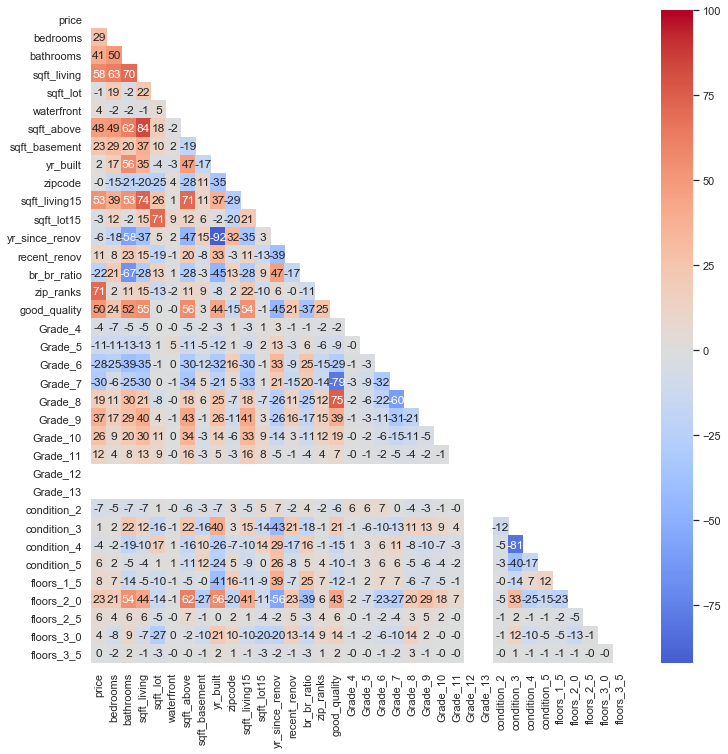

In [1071]:
plt.figure (figsize=(12,12))
mask = np.triu(df_clean.corr())
ax = sns.heatmap(round(df_clean.corr()*100)
                 ,annot=True
                 ,mask=mask
                 ,cmap='coolwarm'
                 ,center=0)
#ax.set_ylim((0,16))
#ax.set_xlim((0,16));

correlated with price:
* sqft above
* sqft living 15
* sqft living
* bathrooms
* bedrooms
* zip ranks
* grades to an extent

autocorrelated:
* sqft_lot 15 with sqft_lot
* sqft_living with sqft_above and sqft_living and sqft_living 15

not correlated:
* condition
* yr built
* waterfront (data missing?)

# pairplots

* in chunks, because of to many variables

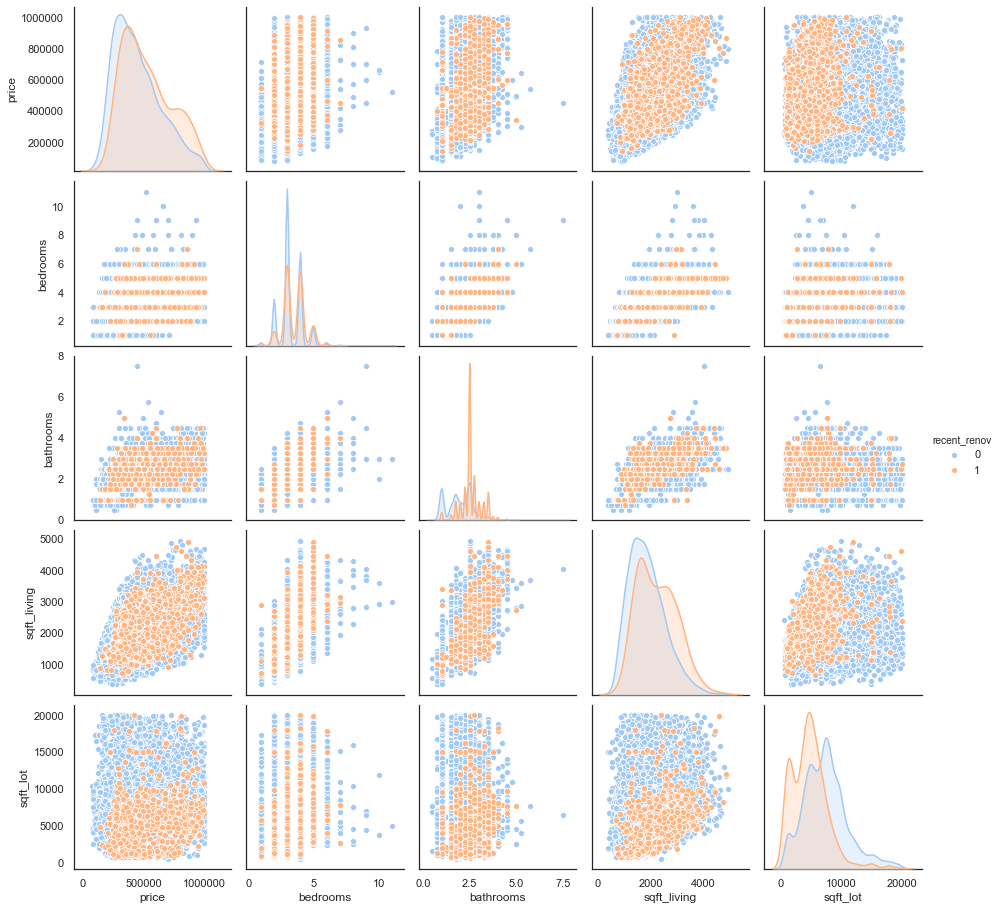

In [1079]:
colspp = ["price"]
colspp.extend(list(df_clean.columns[1:5]))
sns.pairplot(df_clean, vars=colspp, hue="recent_renov");

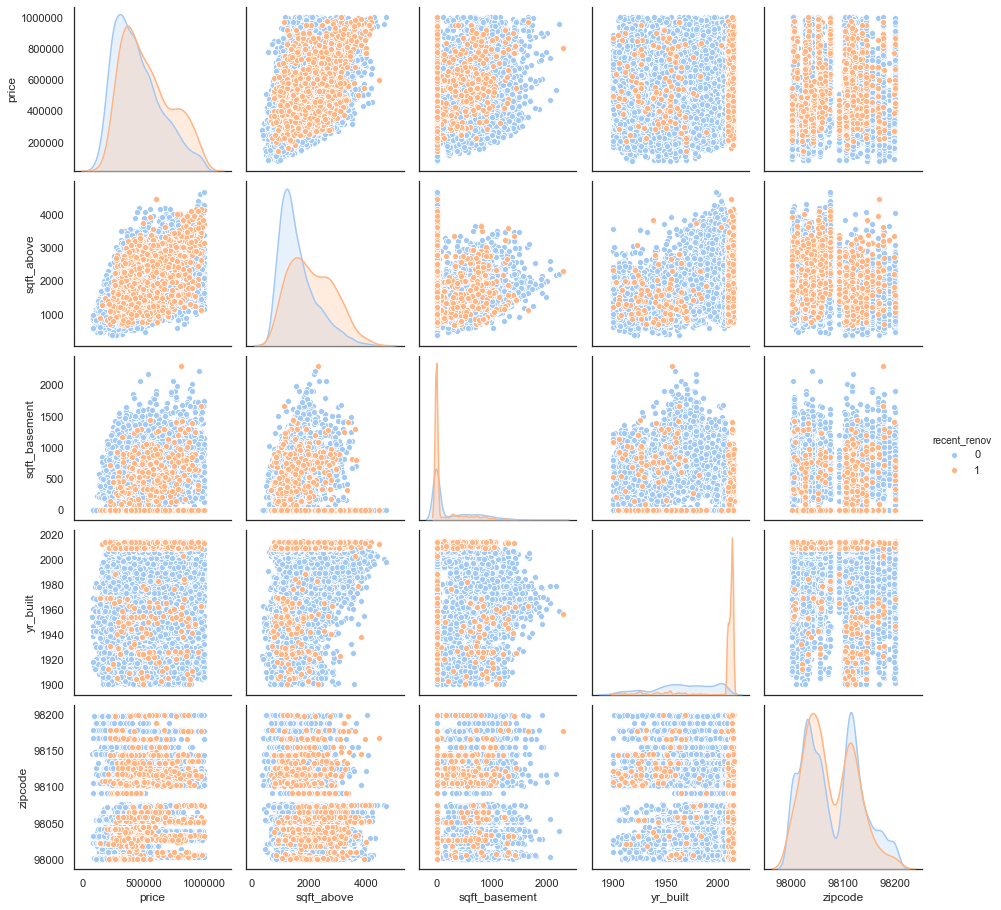

In [1080]:
colspp = ["price"]
colspp.extend(list(df_clean.columns[6:10]))
sns.pairplot(df_clean, vars=colspp, hue="recent_renov");

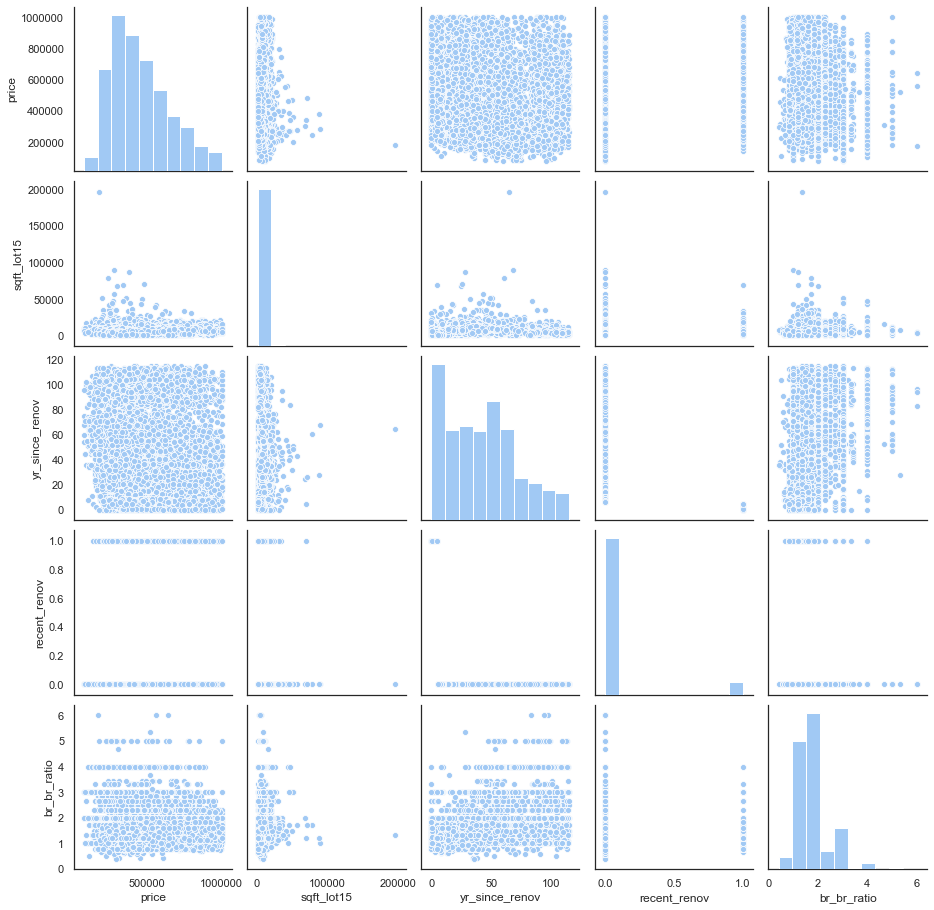

In [1082]:
colspp = ["price"]
colspp.extend(list(df_clean.columns[11:15]))

sns.pairplot(df_clean, vars=colspp);

* more pairplots not useful because of categoricals

* pairplot similar insight to correlation matrix

# 6. Predictive Modeling

## 6.1. modeling for all homes fitting criteria ignoring recent renovation

* creature train and test sets

In [1085]:
y = df_clean.price
X_train, X_test, y_train, y_test = train_test_split(df_clean, y, test_size=0.2)

* brute force method iterating over every aspect and adding only the most useful (according to r square adjust) the do it again with the last step
* ignore price as it is the target
* ignore zipcodes because the numbers are not useful for prediction

In [1086]:
cols = list(df_clean.columns)
cols.append("")
cols.pop(cols.index("price"))
cols.pop(cols.index("zipcode"))
formula_list = []
nkey = ""
formula = "price ~ "
n=0
while len(cols) > 0:
    formula += nkey + " + "
    cols.pop(cols.index(nkey))
    a = {elm : smf.ols(formula=formula+ " "+elm, data=X_train).fit().rsquared_adj for elm in cols}
    for key, value in a.items():
        if  value == max(a.values()):
            nkey = key
            formula_list.append(key)
            print(str(n) + ":"+key + ": rsquared_adj: " + str(value))
            n+=1

0:zip_ranks: rsquared_adj: 0.4979392645014208
1:sqft_living: rsquared_adj: 0.7297608690748147
2:yr_built: rsquared_adj: 0.7414374162488258
3:good_quality: rsquared_adj: 0.7606150561380003
4:Grade_8: rsquared_adj: 0.7737905551635836
5:Grade_7: rsquared_adj: 0.7787228053286399
6:recent_renov: rsquared_adj: 0.7818331881541744
7:bathrooms: rsquared_adj: 0.7838564904286958
8:waterfront: rsquared_adj: 0.785341834436255
9:condition_5: rsquared_adj: 0.7867609103786078
10:sqft_lot15: rsquared_adj: 0.788004570873293
11:sqft_living15: rsquared_adj: 0.7896145116228409
12:Grade_9: rsquared_adj: 0.7905269555440999
13:floors_3_0: rsquared_adj: 0.7912114694367746
14:bedrooms: rsquared_adj: 0.791754439150944
15:condition_4: rsquared_adj: 0.7922271066487114
16:condition_3: rsquared_adj: 0.7927276344182942
17:Grade_10: rsquared_adj: 0.793197954131127
18:Grade_11: rsquared_adj: 0.793197954131127
19:Grade_5: rsquared_adj: 0.7935023654227312
20:br_br_ratio: rsquared_adj: 0.7936856130449254
21:floors_1_5: rs

* dynamically adjust formula according to index you think is the most useful
* here i chose the first four, as they are the most relevant and can be well interpreted

In [1087]:
formula = "price ~ "+" + ".join(formula_list[0:4])
print(formula)

price ~ zip_ranks + sqft_living + yr_built + good_quality


* fit criteria chosen using ols model

In [1089]:
smf.ols(formula=formula, data=X_train).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.761
Model:                            OLS   Adj. R-squared:                  0.761
Method:                 Least Squares   F-statistic:                     8244.
Date:                Thu, 05 Mar 2020   Prob (F-statistic):               0.00
Time:                        17:29:16   Log-Likelihood:            -1.3368e+05
No. Observations:               10378   AIC:                         2.674e+05
Df Residuals:                   10373   BIC:                         2.674e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     2.199e+06   7.07e+04     31.122      0.000    2.06e+06    2.34e+06
zip_ranks     6059.0793     53.251    113.783      0.000    5954.696    6163.462
sqft_living    125.3762      1.596     78.544      0.000     122.247     128.505
yr_built     -1119.2448     36.062    -31.036      0.000   -1189.934   -1048.556
good_quality   7.07e+04   2451.026     28.846      0.000    6.59e+04    7.55e+04
==============================================================================
Omnibus:                      710.071   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1453.129
Skew:                           0.468   Prob(JB):                         0.00
Kurtosis:                       4.576   Cond. No.                     2.11e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.11e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

* plot residuals

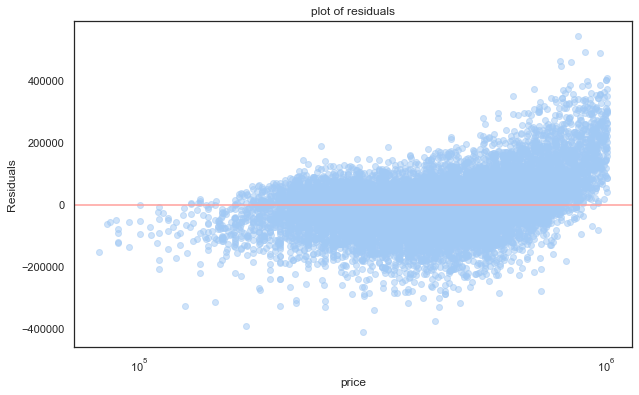

In [1090]:
plt.scatter(x=X_train.price, y=smf.ols(formula=formula, data=X_train).fit().resid, alpha = 0.5)
plt.title("plot of residuals")
plt.axhline(color='r')
plt.ylabel("Residuals")
plt.xlabel("price")
plt.xscale("log");


* plot predicted versus true price

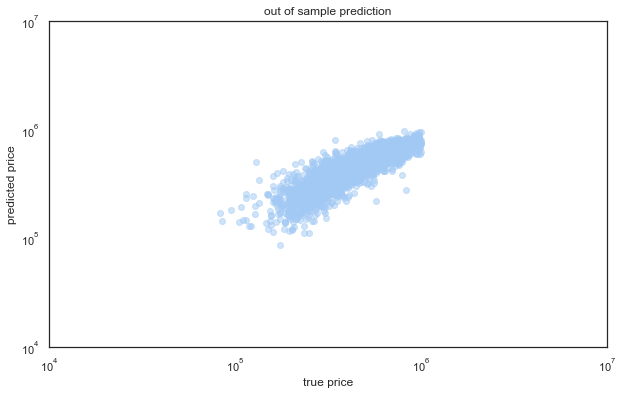

In [1091]:
y_pred = smf.ols(formula=formula, data = X_train).fit().predict(X_test)
plt.scatter(x=y_test, y=y_pred, alpha = 0.5)
plt.ylabel("predicted price")
plt.xlabel("true price")
plt.title("out of sample prediction")
plt.xscale("log")
plt.yscale("log")
plt.ylim(10000,10000000)
plt.xlim(10000,10000000);
                 



* print prediction quality values
    * square root of mean squared error
    * R2 score
    * error divided by mean price in percent

In [1092]:
print("Mean Error (less is better):" + str(np.sqrt(mean_squared_error(y_test, y_pred))))
print("R2 score (closer to 1 is better):" + str(r2_score(y_test, y_pred)))

print("proportion of error to price mean:"+str((np.sqrt(mean_squared_error(y_test, y_pred))/df_clean.price.mean())*100))

Mean Error (less is better):93905.24322243841
R2 score (closer to 1 is better):0.7607609468882901
proportion of error to price mean:20.44611749300873


## 6.2 Prediction for new and newly renovated houses

* same as above only using recently renovated as data
* also not using yr built and recent renov as they are not relevant for this question

In [1095]:
y = df_clean[df_clean.recent_renov == 1].price
X_train2, X_test2, y_train2, y_test2 = train_test_split(df_clean[df_clean.recent_renov == 1], y, test_size=0.2)

In [1096]:
cols = list(df_clean.columns)
cols.append("")
cols.pop(cols.index("price"))
cols.pop(cols.index("recent_renov"))
cols.pop(cols.index("yr_built"))
cols.pop(cols.index("zipcode"))

nkey = ""
formula = "price ~ "
formula_list = []
n=0
while len(cols) > 0:
    formula += nkey + " + "
    cols.pop(cols.index(nkey))
    a = {elm : smf.ols(formula=formula+ " "+elm, data=X_train2).fit().rsquared_adj for elm in cols}
    for key, value in a.items():
        if  value == max(a.values()):
            nkey = key
            formula_list.append(key)
            print(str(n) + ":"+key + ": rsquared_adj: " + str(value))
            n+=1

0:zip_ranks: rsquared_adj: 0.4830927988699648
1:sqft_living: rsquared_adj: 0.7698463070670912
2:Grade_9: rsquared_adj: 0.7790753431004842
3:Grade_10: rsquared_adj: 0.7907961894537692
4:Grade_11: rsquared_adj: 0.796570352963125
5:sqft_living15: rsquared_adj: 0.8026004538358248
6:yr_since_renov: rsquared_adj: 0.8056297929105194
7:floors_2_0: rsquared_adj: 0.8072301148961868
8:floors_2_5: rsquared_adj: 0.80879084319646
9:good_quality: rsquared_adj: 0.8103134151555788
10:Grade_8: rsquared_adj: 0.8103134151555788
11:floors_3_0: rsquared_adj: 0.8112293149020633
12:floors_1_5: rsquared_adj: 0.8125747451583624
13:bathrooms: rsquared_adj: 0.8129797059277313
14:condition_5: rsquared_adj: 0.813031593807509
15:waterfront: rsquared_adj: 0.813031593807509
16:good_quality: rsquared_adj: 0.813031593807509
17:Grade_4: rsquared_adj: 0.813031593807509
18:Grade_12: rsquared_adj: 0.813031593807509
19:Grade_13: rsquared_adj: 0.813031593807509
20:condition_2: rsquared_adj: 0.813031593807509
21:floors_3_5: rs

* chose first two aspects as they are the most interpretable

In [1097]:
formula = "price ~ "+" + ".join(formula_list[0:2])
print(formula)

price ~ zip_ranks + sqft_living


In [1098]:
smf.ols(formula=formula, data=X_train2).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.770
Model:                            OLS   Adj. R-squared:                  0.770
Method:                 Least Squares   F-statistic:                     1329.
Date:                Thu, 05 Mar 2020   Prob (F-statistic):          8.42e-254
Time:                        17:32:14   Log-Likelihood:                -10249.
No. Observations:                 795   AIC:                         2.050e+04
Df Residuals:                     792   BIC:                         2.052e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -2.922e+04    1.2e+04     -2.432      0.015   -5.28e+04   -5637.982
zip_ranks    7383.7614    193.584     38.142      0.000    7003.764    7763.759
sqft_living   141.1409      4.488     31.449      0.000     132.331     149.951
==============================================================================
Omnibus:                       54.520   Durbin-Watson:                   2.038
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               71.241
Skew:                           0.586   Prob(JB):                     3.39e-16
Kurtosis:                       3.881   Cond. No.                     8.45e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.45e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

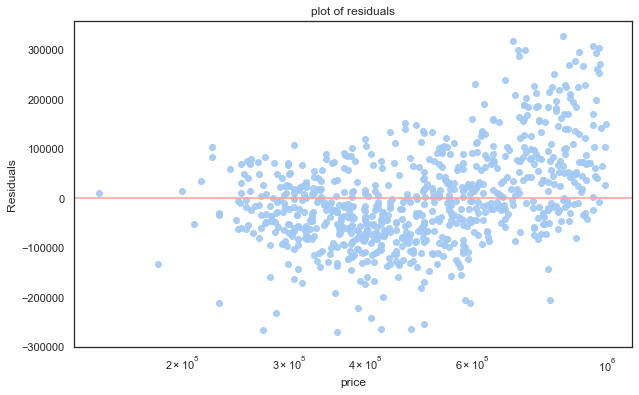

In [1099]:
plt.scatter(x=X_train2.price, y=smf.ols(formula=formula, 
                                        data=X_train2).fit().resid, alpha = 0.9)
plt.title("plot of residuals")
plt.axhline(color='r')
plt.ylabel("Residuals")
plt.xlabel("price")
plt.xscale("log")
plt.savefig('figures/residual_plot_recent_renov',dpi=300);

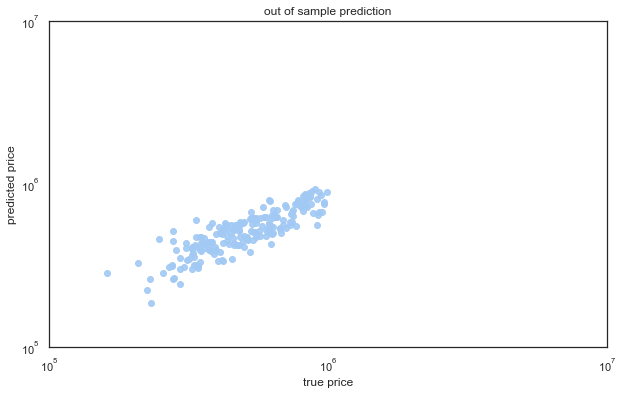

In [1100]:

y_pred2 = smf.ols(formula=formula, 
                  data=X_train2).fit().predict(X_test2)
plt.scatter(x=y_test2, y=y_pred2, alpha = 0.9)
plt.ylabel("predicted price")
plt.xlabel("true price")
plt.title("out of sample prediction")
plt.xscale("log")
plt.yscale("log")
plt.ylim(100000,10000000)
plt.xlim(100000,10000000)
plt.savefig('figures/error_plot_recent_renov',dpi=300);

In [1101]:
print("Mean Error (less is better):" + str(np.sqrt(mean_squared_error(y_test2, y_pred2))))
print("R2 score (closer to 1 is better):" + str(r2_score(y_test2, y_pred2)))

print("proportion of error to price mean:"+str((np.sqrt(mean_squared_error(y_test2, y_pred2))/X_test2.price.mean())*100))

Mean Error (less is better):99344.6076731753
R2 score (closer to 1 is better):0.7414949619500477
proportion of error to price mean:18.535471169536084


# 7. Visualization

## count plot 
* compare number of homes according to quality and renovation status

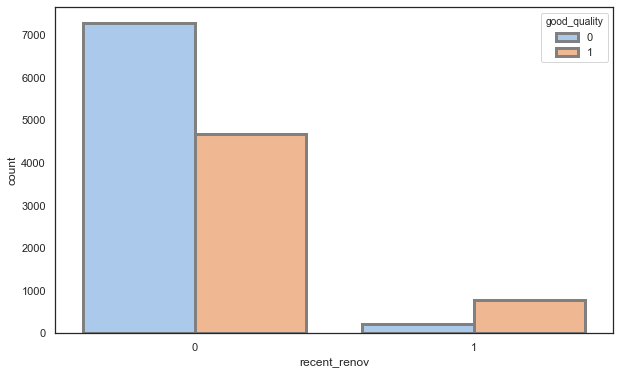

In [958]:
plt.figure (figsize=(10,6))
sns.countplot(df_clean.recent_renov, hue=df_clean.good_quality, edgecolor="grey", linewidth=3)
plt.savefig('figures/good_quality_counts_by_recent_renov.png',dpi=300);

## price by quality and renov status

* insight if renovated houses are more expensive depending on quality

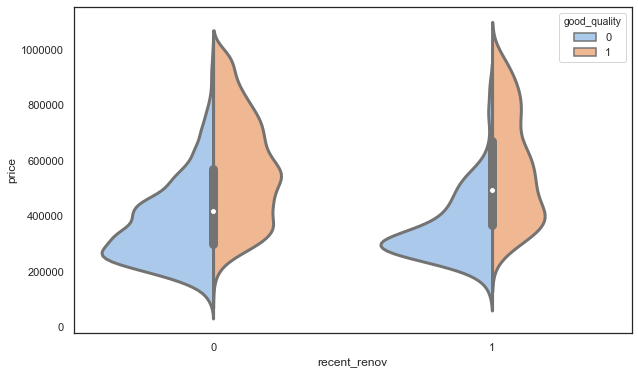

In [1102]:
plt.figure (figsize=(10,6))
sns.violinplot(x=df_clean.recent_renov,y=df_clean.price, 
            hue=df_clean.good_quality,split=True, linewidth=3)
plt.savefig('figures/price_by_renov_status.png',dpi=300);

## livingarea by quality and renov status

* insight if renovated houses have more living area depending on quality

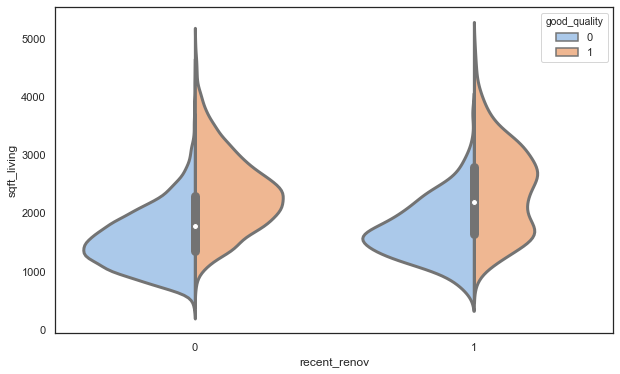

In [1103]:
plt.figure (figsize=(10,6))
sns.violinplot(x=df_clean.recent_renov,y=df_clean.sqft_living, 
            hue=df_clean.good_quality,split=True, linewidth=3)
plt.savefig('figures/sqft_living_by_renov_status.png',dpi=300);

## lot area by quality and renov status

* insight if renovated houses have more lot area depending on quality

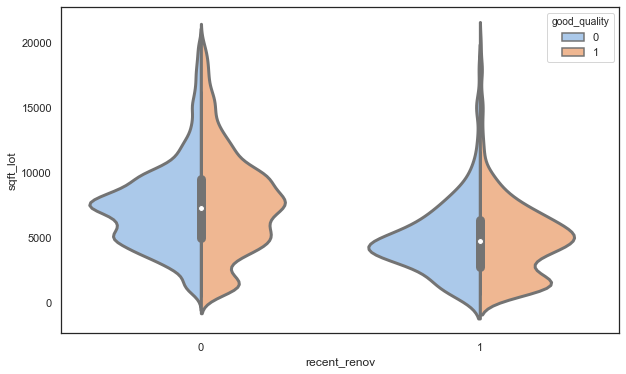

In [1104]:
plt.figure (figsize=(10,6))
sns.violinplot(x=df_clean.recent_renov,y=df_clean.sqft_lot, 
            hue=df_clean.good_quality,split=True, linewidth=3)
plt.savefig('figures/sqft_lot_by_renov_status.png',dpi=300);

## basement area by quality and renov status

* insight if renovated houses have more basement area depending on quality

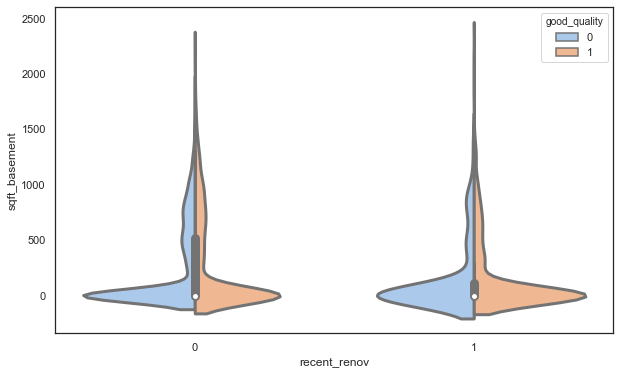

In [1105]:
plt.figure (figsize=(10,6))
sns.violinplot(x=df_clean.recent_renov,y=df_clean.sqft_basement, 
            hue=df_clean.good_quality,split=True, linewidth=3)
plt.savefig('figures/sqft_basement_by_renov_status.png',dpi=300);

## lot area by price for renoated homes 

* insight if lot area is more expensive

<Figure size 720x720 with 0 Axes>

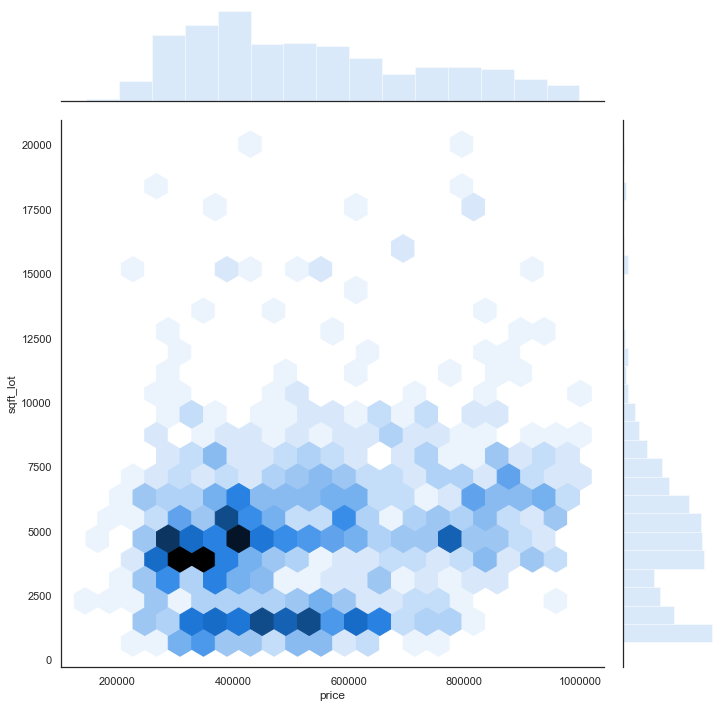

In [1106]:
plt.figure (figsize=(10,10))
sns.jointplot(x="price", y="sqft_lot", kind="hex", height=10, data=df_clean.query("recent_renov == 1") )
plt.savefig('figures/sqft_lot_by_price.png',dpi=300);

## Map prep

* preparing mape shape file

In [1107]:
shp_path="./zip_map/Zipcodes_for_King_County_and_Surrounding_Area__zipcode_area.shp"
kc = shp.Reader(shp_path)

In [1108]:
def read_shapefile(sf):
    """
    Read a shapefile into a Pandas dataframe with a 'coords' 
    column holding the geometry information. This uses the pyshp
    package
    """
    fields = [x[0] for x in sf.fields][1:]
    records = sf.records()
    shps = [s.points for s in sf.shapes()]
    df = pd.DataFrame(columns=fields, data=records)
    df = df.assign(coords=shps)
    return df

In [1109]:
kc_map= read_shapefile(kc)

## map of relevant

* zip code areas containing renovated homes fitting criteria

* defining plotting function

In [1113]:
def plot_map_fill_multiples_ids(title, comuna, sf, 
                                              x_lim = None, 
                                               y_lim = None, 
                                               figsize = (11,9), 
                                               color = 'r'):
    '''
    Plot map with lim coordinates
    '''
    
    plt.figure(figsize = figsize)
    fig, ax = plt.subplots(figsize = figsize)
    fig.suptitle(title, fontsize=16)
    for shape in sf.shapeRecords():
        x = [i[0] for i in shape.shape.points[:]]
        y = [i[1] for i in shape.shape.points[:]]
        ax.plot(x, y, 'k')
            
    for id in comuna:
        shape_ex = sf.shape(id)
        x_lon = np.zeros((len(shape_ex.points),1))
        y_lat = np.zeros((len(shape_ex.points),1))
        for ip in range(len(shape_ex.points)):
            x_lon[ip] = shape_ex.points[ip][0]
            y_lat[ip] = shape_ex.points[ip][1]
        ax.fill(x_lon,y_lat, color)
             
        x0 = np.mean(x_lon)
        y0 = np.mean(y_lat)
        #plt.text(x0, y0, sf.records()[id][1], fontsize=10)
    
    if (x_lim != None) & (y_lim != None):     
        plt.xlim(x_lim)
        plt.ylim(y_lim)

* get zip codes of releveant homes and assigning ids of shape file

In [1114]:
zip_of_rel = list(df_clean[df_clean.recent_renov == 1].zipcode.unique())

In [1115]:
id_of_rel=[]
for elm in zip_of_rel:
    for idx, elm2 in enumerate(kc.records()):
        if elm2[1] == elm:
            id_of_rel.append(elm2[0])
    

* plot map using map function and assigned ids

<Figure size 792x648 with 0 Axes>

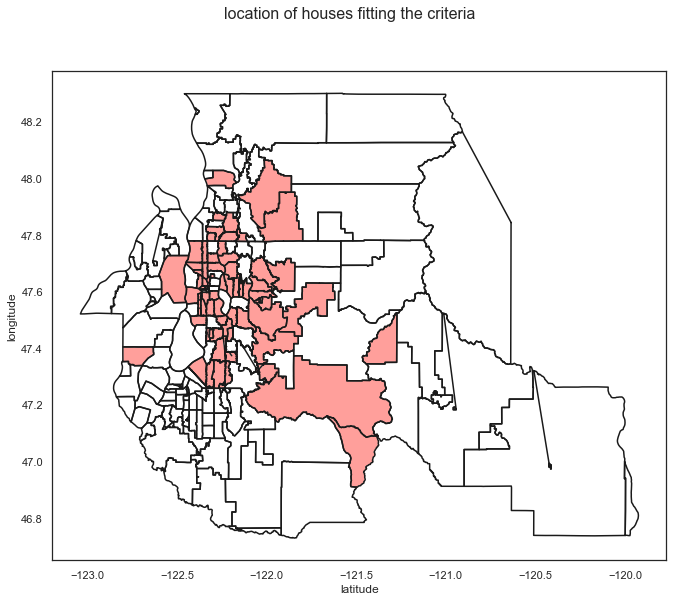

In [1116]:
plot_map_fill_multiples_ids("location of houses fitting the criteria",id_of_rel,kc);
plt.ylabel("longitude")
plt.xlabel("latitude")
plt.savefig('figures/map_by_rel.png',dpi=300);

## map of all
* same as above with all homes fitting criteria

In [1118]:
zip_of_all = sorted(list(df_clean.zipcode.unique()))
id_of_all=[]
for elm in zip_of_all:
    for elm2 in kc.records():
        if elm2[1] == elm:
            id_of_all.append(elm2[0])
    

In [1120]:
zip_of_all = sorted(list(df_clean.zipcode.unique()))
zip_code_rank = list(df_clean.groupby("zipcode").mean().zip_ranks)
rank_of_all=[]
for idx, elm in enumerate(zip_of_all):
    for elm2 in kc.records():
        if elm2[1] == elm:
            rank_of_all.append(zip_code_rank[idx])
    

<Figure size 792x648 with 0 Axes>

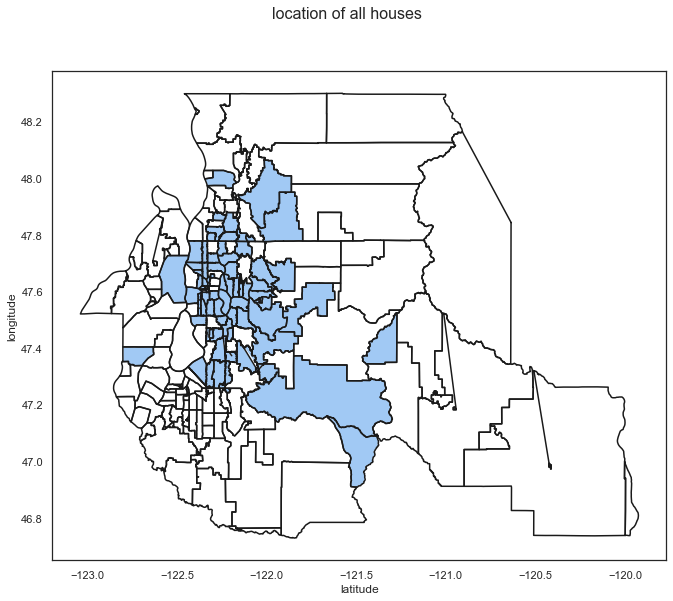

In [1121]:
plot_map_fill_multiples_ids("location of all houses ",id_of_all,kc, color="b")
plt.ylabel("longitude")
plt.xlabel("latitude")
plt.savefig('figures/map_all.png',dpi=300);

## color map by zip ranks

* color map by zip ranks of all homes fitting criteria

* define new map plotting function using heatmap colors

In [1122]:
def plot_map_fill_multiples_ids_tone(sf, title, comuna,  
                                     print_id, color_ton, 
                                     
                                     x_lim = None, 
                                     y_lim = None, 
                                     figsize = (11,9)):
    '''
    Plot map with lim coordinates
    '''
        
    plt.figure(figsize = figsize)
    fig, ax = plt.subplots(figsize = figsize)
    fig.suptitle(title, fontsize=16)
    for shape in sf.shapeRecords():
        x = [i[0] for i in shape.shape.points[:]]
        y = [i[1] for i in shape.shape.points[:]]
        ax.plot(x, y, 'k')
            
    for id in comuna:
        shape_ex = sf.shape(id)
        x_lon = np.zeros((len(shape_ex.points),1))
        y_lat = np.zeros((len(shape_ex.points),1))
        for ip in range(len(shape_ex.points)):
            x_lon[ip] = shape_ex.points[ip][0]
            y_lat[ip] = shape_ex.points[ip][1]
        ax.fill(x_lon,y_lat, color_ton[comuna.index(id)])
        if print_id != False:
            x0 = np.mean(x_lon)
            y0 = np.mean(y_lat)
            plt.text(x0, y0, id, fontsize=10)
    if (x_lim != None) & (y_lim != None):     
        plt.xlim(x_lim)
        plt.ylim(y_lim)
        

* define color function assiging heat map areas to ids

In [1123]:
def calc_color(data, color=None):
        if color   == 1: 
            color_sq =  ['#dadaebFF','#bcbddcF0','#9e9ac8F0',
                        '#807dbaF0','#6a51a3F0','#54278fF0']; 
            colors = 'Purples';
        elif color == 2: 
            color_sq = ['#c7e9b4','#7fcdbb','#41b6c4',
                        '#1d91c0','#225ea8','#253494']; 
            colors = 'YlGnBu';
        elif color == 3: 
            color_sq = ['#f7f7f7','#d9d9d9','#bdbdbd',
                        '#969696','#636363','#252525']; 
            colors = 'Greys';
        elif color == 9: 
            color_sq = ['#ff0000','#ff0000','#ff0000',
                        '#ff0000','#ff0000','#ff0000']
        else:            
            color_sq = ['#ffffd4','#fee391','#fec44f',
                        '#fe9929','#d95f0e','#993404']; 
            colors = 'YlOrBr';
        new_data, bins = pd.qcut(data, 6, retbins=True, 
        labels=list(range(6)))
        color_ton = []
        for val in new_data:
            color_ton.append(color_sq[val]) 
        if color != 9:
            colors = sns.color_palette(colors, n_colors=6)
            sns.palplot(colors, 0.6);
            for i in range(6):
                print ("\n"+str(i+1)+': '+str(int(bins[i]))+
                       " => "+str(int(bins[i+1])-1), end =" ")
            print("\n\n   1   2   3   4   5   6")    
        return color_ton, bins;

* creature heat map colors and bins and assiging them to the ranks
* plotting map with heatmap colors


1: 0 => 11 
2: 12 => 21 
3: 22 => 33 
4: 34 => 44 
5: 45 => 55 
6: 56 => 68 

   1   2   3   4   5   6


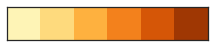

<Figure size 792x648 with 0 Axes>

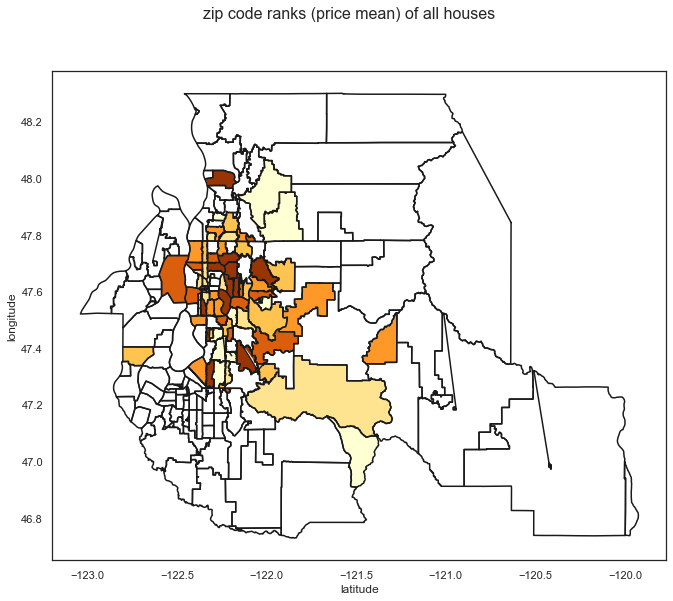

In [1124]:


color_ton, bins = calc_color(rank_of_all)
plt.savefig('figures/map_by_price_scale.png',dpi=300)




plot_map_fill_multiples_ids_tone(sf=kc, title="zip code ranks (price mean) of all houses",
                                 comuna=id_of_all, print_id=False, color_ton=color_ton)
plt.ylabel("longitude")
plt.xlabel("latitude")
plt.savefig('figures/map_by_price.png',dpi=300);

# A. Summary

* Homes in new condition are found in almost all areas covered
* Homes in new condition are not necessarily more expensive
    * But they are on average in a better condition
* Homes in King County rarely have basement
* Living area and location are most import factors for determining the price
    * Homes in new condition and small living areas are available, but of lower quality
    * As these homes are found in almost all areas covered, we can offer homes in inexpensive locations


# B. Future Work

* Deeper look into location
    * find the inexpensive location with good homes fitting criteria
    * take waterfront into account
    * maybe take commute into account
    
* deeper look at floor levels, bathrooms and bedrooms